In [1]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import torch

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from numpy.lib.stride_tricks import sliding_window_view
import torch.nn.functional as F
from models.last_layer_models import LLI, train_last_layer_det, get_post_pred_dens

from models.mc_dropout import MCDropoutNet
from models.bnn import BNN, train_bnn
from models.gibbs_sampler import gibbs_sampler, get_pred_post_dist, get_prediction_interval_coverage
from models.vi import fit_vi_post_hoc, predictive_posterior
from models.sg_mcmc import train_sg_mcmc
from tqdm import tqdm

from utils.coverage import get_coverage_gaussian, get_coverage_y_hats

np.random.seed(100)

# Probabilistic NNs on 1d regression

## 1. Visualization on noisy sine function

We want to visualize the predictions of different probabilistic NNs on 

$y = \sin(x) + \varepsilon$, with $\varepsilon \sim \mathcal{N}(0, \sigma_0^2)$.

### 1.1 Data
We sample 200 datapoints from the function with $x \in [-4,4]$. \
Then we randomly split the data into 100 points for training and validation, respectively.

Text(0.5, 1.0, 'Training/Validation split')

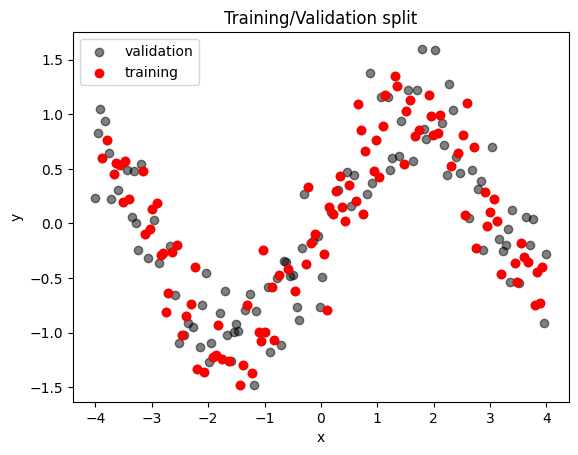

In [2]:
def f(x: float, noise: bool = True, sigma_eps: float = 0.1):
    """Generates a sample y_i from y = sin(x) + varepsilon."""
    y = math.sin(x)
    if noise:
        y += sigma_eps*np.random.randn(1)
    return y

# draw data
sigma_eps = 0.3
xs = np.linspace(-4,4,200)
ys = np.array([f(x = x, noise = True, sigma_eps = sigma_eps) for x in xs])

# sample train indices
train_idx = np.random.choice(len(xs), size=100, replace=False)

xs_train = torch.tensor(xs[train_idx]).unsqueeze(-1).float()
ys_train = torch.tensor(ys[train_idx]).float()

all_idx = np.arange(len(xs))
val_idx = np.setdiff1d(all_idx, train_idx)

# visualize train/val split
fig, axs = plt.subplots(1,1)
axs.scatter(xs, ys, c = 'black', label = 'validation', alpha =.5)
axs.scatter(xs_train, ys_train, c = 'red', label = 'training', alpha = 1)
axs.legend()
axs.set_xlabel('x')
axs.set_ylabel('y')
axs.set_title("Training/Validation split")

Now we create the dataloaders for training and validation

In [3]:
data = TensorDataset(xs_train, ys_train)
train_set, val_set = torch.utils.data.random_split(data, [80, 20])
dataloader_train = DataLoader(train_set, shuffle = True, batch_size=5)
dataloader_val = DataLoader(val_set, shuffle = True, batch_size=20)

### 1.2 Models
We fit three different models:
- **LLI**: last-layer inference with an isotropic Gaussian prior on $w$ and $\sigma_0^2$ is assumed to be known. This gives a closed-form posterior
- **MC dropout**: Same network as for the LLI, but with dropout layers in between the fully connected layers.
- **BNN**: full BNN trained with Bayes-by-Backprop and isotropic Gaussian priors on the weights.

In [4]:
# all models have 4 layers with 100, 100, 5 and 1 neuron(s), respectively.
model_dims = [1, 100, 100, 100, 50, 1]
num_epochs = 100

### 1.2.1 LLI

100%|██████████| 100/100 [00:00<00:00, 154.82it/s]


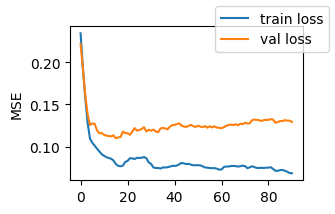

In [5]:
# train deep feature projector psi
lli_net = LLI(model_dims)
sigma_0 = 0.3

lli_net, losses_train, losses_val = train_last_layer_det(model = lli_net, 
                                                         dataloader_train = dataloader_train,
                                                         dataloader_val = dataloader_val, 
                                                         num_epochs = num_epochs)

# plot losses
fig, axs = plt.subplots(1,1, figsize = (3,2))
axs.plot(sliding_window_view(np.array(losses_train), 10).mean(axis=1), label = 'train loss')
axs.plot(sliding_window_view(np.array(losses_val), 10).mean(axis=1), label = 'val loss')
axs.set_ylabel('MSE')
fig.legend()

In [6]:
lli_net.eval()

# fit last-layer posterior
Psi = lli_net.get_ll_embedd(xs_train)
d = Psi.shape[1]
Sigma_N_inv = (1/sigma_0**2)*torch.eye(d) + (1/sigma_eps**2)*(Psi.T @ Psi)
Sigma_N = torch.linalg.inv(Sigma_N_inv).detach()
mu_N = Sigma_N @ ((1/sigma_eps**2)*(Psi.T @ ys_train)).detach()

### 1.2.2 MC dropout

100%|██████████| 100/100 [00:00<00:00, 150.79it/s]


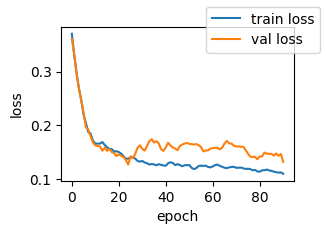

In [7]:
mc_net = MCDropoutNet(model_dims, p = 0.2)

mc_net, losses_train, losses_val = train_last_layer_det(model = mc_net, 
        dataloader_train = dataloader_train,
        dataloader_val = dataloader_val, 
        num_epochs = num_epochs)

# plot losses
fig, axs = plt.subplots(1,1, figsize = (3,2))
axs.plot(sliding_window_view(np.array(losses_train), 10).mean(axis=1), label = 'train loss')
axs.plot(sliding_window_view(np.array(losses_val), 10).mean(axis=1), label = 'val loss')
axs.set_xlabel('epoch')
axs.set_ylabel('loss')
fig.legend()

### 1.2.3 BNN

In [8]:
bnn = BNN()
bnn, losses_train, losses_val = train_bnn(model = bnn, 
                                          num_epochs = num_epochs*2, 
                                          dataloader_train = dataloader_train, 
                                          dataloader_val = dataloader_val)

100%|██████████| 200/200 [00:08<00:00, 23.79it/s]


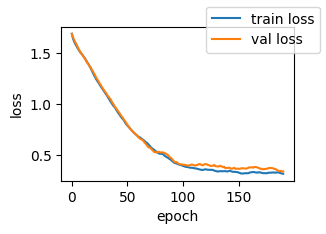

In [9]:
# plot losses
fig, axs = plt.subplots(1,1, figsize = (3,2))
axs.plot(sliding_window_view(np.array(losses_train), 10).mean(axis=1), label = 'train loss')
axs.plot(sliding_window_view(np.array(losses_val), 10).mean(axis=1), label = 'val loss')
axs.set_xlabel('epoch')
axs.set_ylabel('loss')
fig.legend()

## 1.3 Visualization
We now visualize the predictive means and prediction intervals (mean + 2sd) for all models.

In [10]:
# prediction coordinates:
xs_pred_np = np.linspace(-10,10,200)
xs_pred = torch.tensor(xs_pred_np).unsqueeze(-1).float()

# predictions for:
# LLI:
lli_pred_mu, lli_pred_sigma = get_post_pred_dens(model = lli_net, x_star = xs_pred , 
                              mu_N = mu_N, Sigma_N = Sigma_N, sigma_eps = sigma_0 )
# MC dropout
num_samples_mc_dropout = 100
preds = []
with torch.no_grad():
    for _ in range(num_samples_mc_dropout):
        preds.append(mc_net.forward(xs_pred))

ys_samples_mc = torch.stack(preds)
mc_pred_mu = torch.mean(ys_samples_mc, axis = 0).squeeze()
mc_pred_sigma = torch.std(ys_samples_mc, axis = 0).squeeze()

# BNN
bnn.eval()
with torch.no_grad():
    preds = [bnn(xs_pred) for _ in range(100)]  # 100 MC samples
    preds = torch.stack(preds)
    bnn_pred_mu = preds.mean(dim=0).squeeze()
    bnn_pred_std = preds.std(dim=0).squeeze()

/Users/clarahoffmann/Documents/code/last_layer_inference/last-layer-inf/src/models/last_layer_models.py:89: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4416.)
  sigma_sq_star = np.array([sigma_eps**2 + psi_star @ Sigma_N @ psi_star.T for psi_star in psi_stars])


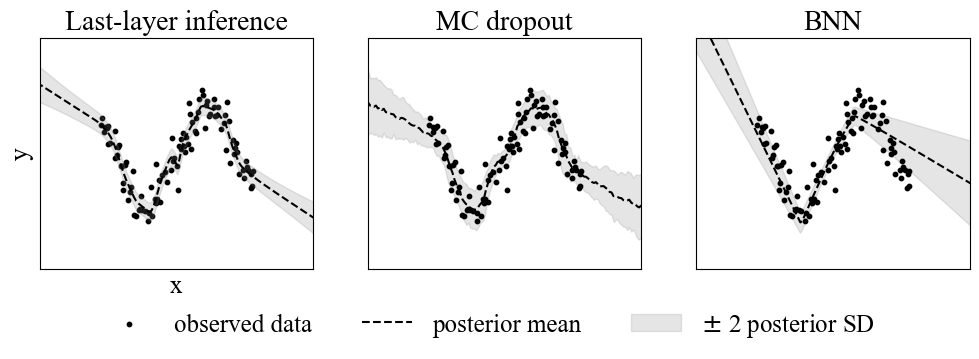

In [11]:
TEXT_SIZE = 18
ys_no_noise = np.array([f(x = x, noise = False, sigma_eps = sigma_eps) for x in xs])
plt.rcParams.update({'font.size': 18, 
                    "font.family": "serif",
                    "font.serif": ["Times New Roman"]})
fig, axs = plt.subplots(1,3,figsize=(12, 3))

for i, title, pred_mus, pred_sigmas in zip(range(3), ['Last-layer inference', 'MC dropout', 'BNN'], 
                                           [lli_pred_mu, mc_pred_mu, bnn_pred_mu], 
                                           [lli_pred_sigma, mc_pred_sigma, bnn_pred_std]):
    if i == 0:
        axs[i].scatter(xs_train, ys_train, c = 'black', label = 'observed data', alpha = 1, s = 10)
        axs[i].plot(xs_pred_np, pred_mus, c = 'black', linestyle = 'dashed', label = 'posterior mean')
        axs[i].fill_between(xs_pred_np, pred_mus - 2*pred_sigmas,  pred_mus + 2*pred_sigmas, color = 'grey', label = r'$\pm$ 2 posterior SD', alpha = 0.2)
        axs[i].set_xlabel('x', size = TEXT_SIZE)
        axs[i].set_ylabel('y', size = TEXT_SIZE)
    else: 
        axs[i].fill_between(xs_pred_np, pred_mus - 2*pred_sigmas,  pred_mus + 2*pred_sigmas, color = 'grey', alpha = 0.2)
        axs[i].plot(xs_pred_np, pred_mus, c = 'black', linestyle = 'dashed')
        axs[i].scatter(xs_train, ys_train, c = 'black', alpha = 1, s = 10)
    
    axs[i].set_title(title, size = 20)
    axs[i].set_xlim(-7,7)
    axs[i].set_ylim(-2.5, 2.5)
    axs[i].set_yticks([], [])
    axs[i].set_xticks([], [])

fig.legend(ncols = 3, loc='lower center', 
           fontsize = TEXT_SIZE, bbox_to_anchor=(0.5, -0.2), frameon=False)
fig.savefig('1d_regression.pdf', bbox_inches='tight')

# 2. Further models and benchmark figure

## 2.1 Further models

In [12]:
# prediction coordinates, here we need the validation points! 
xs_val = torch.tensor(xs[val_idx]).unsqueeze(-1).float()
ys_val = torch.tensor(ys[val_idx]).float()

### 2.1.1 LLI + Ridge + Gibbs

In [13]:
a_tau = 0
b_tau = .02
a_sigma = 0
b_sigma = .02
num_iter = 1000
warm_up = 600
w_sample, tau_sq_sample, sigma_sq_sample = gibbs_sampler(Psi, ys_train, 
                a_tau, b_tau, a_sigma, b_sigma, num_iter, warm_up)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 4285.72it/s]


In [14]:
ys_grid = torch.arange(-5,5, .01)

xs_pred_np = np.linspace(-10,10,200)
xs_pred = torch.tensor(xs_pred_np).unsqueeze(-1).float()

Psi_pred = lli_net.get_ll_embedd(xs_pred)

preds = {'mean': [],
         'var': []}
for i in tqdm(range(Psi_pred.shape[0])):
    pdf_gibbs_ridge , y_mean, y_var = get_pred_post_dist(Psi_pred[i], w_sample, sigma_sq_sample, ys_grid)
    preds['mean'].append(y_mean)
    preds['var'].append(y_var)

rmse_lli = (ys_val.reshape(-1,1) - torch.tensor(np.array(preds['mean']))).pow(2).sqrt()
rmse_lli_gibbs_mean = rmse_lli.mean()
rmse_ll_gibbs_std = rmse_lli.std()


100%|██████████| 200/200 [00:02<00:00, 86.52it/s]


### 2.1.2 LLI + Gaussian diag. VI

In [15]:
sigma_eps_sq = torch.tensor(1)
post_lambdas, elbos = fit_vi_post_hoc(ys = ys_train.detach(), 
                               Psi = Psi.detach(), lr = 1e-3, 
                               num_iter = 100000, sigma_eps_sq = sigma_eps_sq, 
                               sigma_p_sq = torch.tensor(1.0))

100%|██████████| 100000/100000 [00:19<00:00, 5187.71it/s]


Text(0.5, 1.0, 'ELBO')

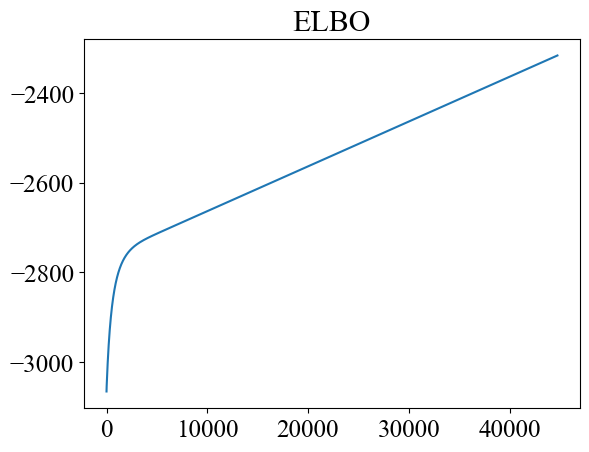

In [16]:
fig, axs = plt.subplots(1,1)
axs.plot(elbos)
axs.set_title('ELBO')

In [17]:
lli_vi_pred_mu, lli_vi_pred_var = predictive_posterior(Psi_pred, post_lambdas['mu'], post_lambdas['sigma'], sigma_eps_sq)
lli_vi_pred_std = np.sqrt(lli_vi_pred_var)

### 2.1.3 SG-MCMC

## 2.2 Error bar plot

In [18]:
# need: test rmse and test log-likelihood
# RMSE

# predictions for:
# LLI:
lli_pred_mu, lli_pred_sigma = get_post_pred_dens(model = lli_net, x_star = xs_val , 
                              mu_N = mu_N, Sigma_N = Sigma_N, sigma_eps = sigma_0 )
rmse_lli = (ys_val.reshape(-1,1) - torch.tensor(lli_pred_mu)).pow(2).sqrt()
rmse_lli_mean = rmse_lli.mean()
rmse_lli_std = rmse_lli.std()

# LLI + closed-form VI
rmse_lli = (ys_val.reshape(-1,1) - lli_vi_pred_mu).pow(2).sqrt()
rmse_lli_vi_mean = rmse_lli.mean()
rmse_lli_vi_std = rmse_lli.std()

# MC dropout
num_samples_mc_dropout = 100
preds = []
with torch.no_grad():
    for _ in range(num_samples_mc_dropout):
        preds.append(mc_net.forward(xs_val))

ys_samples_mc = torch.stack(preds)
mc_pred_mu = torch.mean(ys_samples_mc, axis = 0).squeeze()
mc_pred_sigma = torch.std(ys_samples_mc, axis = 0).squeeze()

rmse_mc = (ys_val.reshape(-1,1) - mc_pred_mu).pow(2).sqrt()
rmse_mc_mean = rmse_mc.mean()
rmse_mc_std = rmse_mc.std()

# BNN
bnn.eval()
bnn_samples = []
with torch.no_grad():
    preds = [bnn(xs_val) for _ in range(100)]  # 100 MC samples
    preds = torch.stack(preds)
    bnn_pred_mu = preds.mean(dim=0).squeeze()
    bnn_pred_std = preds.std(dim=0).squeeze()
    bnn_samples.append(preds)

rmse_bnn = (ys_val.reshape(-1,1) - bnn_pred_mu).pow(2).sqrt()
rmse_bnn_mean = rmse_bnn.mean()
rmse_bnn_std = rmse_bnn.std()


/var/folders/73/tcv3sgb138b9cqckw4zk9r5h0000gn/T/ipykernel_12233/1862458516.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rmse_lli = (ys_val.reshape(-1,1) - lli_vi_pred_mu).pow(2).sqrt()


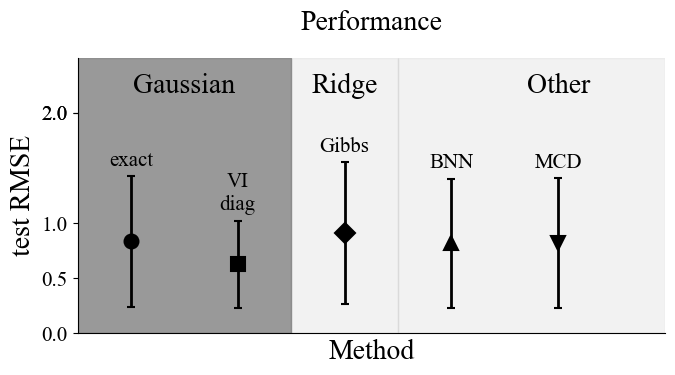

In [19]:
plt.rcParams.update({'font.size': 15, 
                    "font.family": "serif",
                    "font.serif": ["Times New Roman"]})

num_points = 5   # number of methods or configurations per panel
markers = ['o', 's', 'D', '^', 'v', '*', 'P']
linestyles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (3, 1, 1, 1))]

# Create horizontal subplots
fig, axs = plt.subplots(1, 1, figsize=(7, 4), sharey=False)


for i, (mean, std, label, color) in enumerate(zip([rmse_lli_mean, rmse_lli_vi_mean, rmse_lli_gibbs_mean, rmse_bnn_mean, rmse_mc_mean] , 
                                    [rmse_lli_std, rmse_lli_vi_std, rmse_ll_gibbs_std, rmse_mc_std, rmse_bnn_std ], 
                                    ['exact', 'VI\ndiag', 'Gibbs', 'BNN', 'MCD'],
                                    ['black', 'black', 'black', 'black', 'black'])):
    axs.errorbar(
        x=i, 
        y=mean, 
        yerr=std, 
        fmt=markers[i], 
        color='black', 
        markersize=10, 
        capsize=3,
        linestyle=linestyles[i], 
        linewidth=2,
        markeredgewidth=1.5,
        label = label,
    )
    axs.text(i, mean + std + 0.05, label, 
             ha='center', va='bottom', 
             color = color)
axs.set_xticks([])
axs.set_yticks([0, .5,  1, 2,  2])
axs.set_xlim(-0.5, 5)
axs.set_ylim(0, 2.5)
axs.set_title(f'Performance', pad = 20, size = 20)
axs.grid(False)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.set_xlabel('Method', fontsize = 20)
axs.set_ylabel('test RMSE', fontsize = 20)

ymin, ymax = axs.get_ylim()
offset = (ymax - ymin) * 0.15

axs.axvspan(-0.5, 1.5, color='gray', alpha=0.8)
axs.text(0.5, ymax  - offset, "Gaussian", ha='center', va='bottom', fontsize = 20)

axs.axvspan(1.5, 2.5, color='gray', alpha=0.1)
axs.text(2, ymax  - offset, "Ridge", ha='center', va='bottom', fontsize = 20)

axs.axvspan(2.5, 5, color='gray', alpha=0.1)
axs.text(4, ymax  - offset, "Other", ha='center', va='bottom', fontsize = 20)


plt.tight_layout()
plt.show()
fig.savefig('figures/rmse.pdf', bbox_inches = 'tight')

## 2.3 Prediction interval coverage rates

In [20]:
levels = np.linspace(0.001, 0.99, 100)

In [21]:
# Closed-form Gaussian
lli_pred_mu, lli_pred_sigma 
coverage_lli = get_coverage_gaussian(lli_pred_mu, lli_pred_sigma, ys_train.detach().numpy(), levels=np.linspace(0.01, 0.99, 100))

# VI Gaussian
coverage_lli_vi = get_coverage_gaussian(lli_vi_pred_mu, lli_vi_pred_std, ys_train.detach().numpy(), levels=np.linspace(0.01, 0.99, 100))

# Gibbs + ridge
coverage_gibbs_ridge = get_prediction_interval_coverage(ys_grid, ys_train, torch.tensor(pdf_gibbs_ridge), levels)

# MC dropout
coverage_mc_dropout = get_coverage_y_hats(ys_samples_mc, ys_train, levels)

# BNN
coverage_bnn = get_coverage_y_hats(torch.stack(bnn_samples).squeeze(), ys_train, levels)

100%|██████████| 100/100 [00:00<00:00, 29289.83it/s]


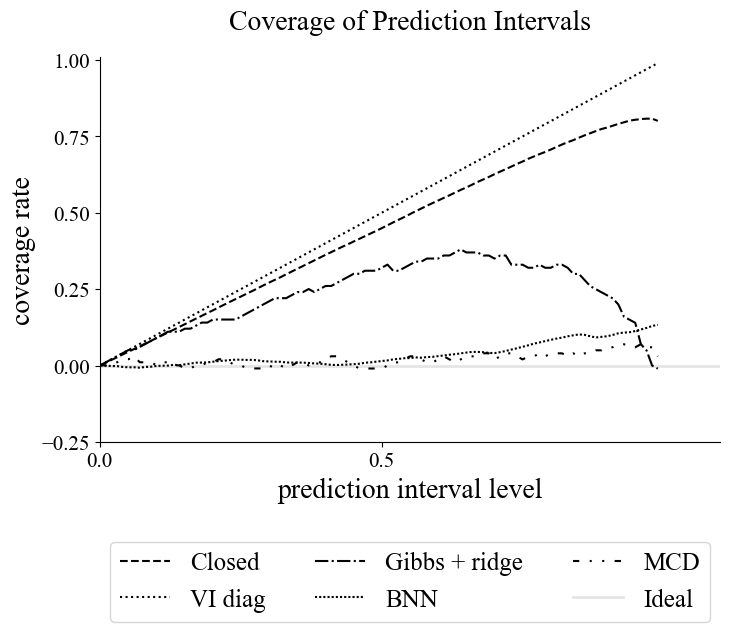

In [22]:
fig, axs = plt.subplots(1,1, figsize = (8,5))
for i, (coverage, label, linestyle ) in enumerate(zip([coverage_lli, coverage_lli_vi, coverage_gibbs_ridge, coverage_bnn, coverage_mc_dropout], 
                                           ['Closed', 'VI diag', 'Gibbs + ridge', 'BNN', 'MCD'],
                                           ['dashed', 'dotted', 'dashdot', (0, (1, 1)), (0, (3, 5, 1, 5, 1, 5)) ])):
    axs.plot(levels,  levels - coverage, 
             linestyle = linestyle, 
             label = label, color = 'black'
             )

axs.axhline(y=0, color='black', linestyle='-', 
            linewidth=2, label='Ideal', alpha = .1)

axs.legend(loc = 'lower center', ncols = 3, bbox_to_anchor=(0.5, -0.5), fontsize = 18)
axs.set_xticks(np.arange(-1, 1, .5))
axs.set_yticks(np.arange(-0.25, 1.5, .25))
axs.set_xlim(-0, 1.1)
axs.set_ylim(-.25, 1.01)
axs.set_title(f'Coverage of Prediction Intervals', pad = 20, size = 20)
axs.grid(False)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.set_xlabel('prediction interval level', fontsize = 20)
axs.set_ylabel('coverage rate', fontsize = 20)
fig.savefig('figures/coverage.pdf', bbox_inches = 'tight')